# Decomposition

In [1]:
from utils import (
    load_dataset,
    get_images,
    transform_points,
    predict,
    SCALING_FACTOR
)
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
filename = 'mini3.json'

with open(filename, 'r') as file:
    data = json.load(file)
K = data['mtx']
dist = data['dist']
K = np.array(K)
dist = np.array(dist)

In [3]:
def get_camera_position(pv_img, tv_img='DJI_0017'):
    reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv = load_dataset(pv_img, tv_img)
    img_pv, img_tv = get_images(pv_img, tv_img)

    reference_pts_pv_arr, reference_pts_tv_arr, validation_pts_pv_arr, validation_pts_tv_arr = transform_points(
        reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv)
    reference_pts_pv_arr = reference_pts_pv_arr[:,:2].astype(np.float32)
    reference_pts_tv_arr = reference_pts_tv_arr[:,:2].astype(np.float32) 

    image_points = reference_pts_pv_arr
    object_points = reference_pts_tv_arr
    object_points = np.pad(
        object_points, 
        ((0, 0), (0, 1)), 
        mode = 'constant', 
        constant_values = 0
    )
    
    retval, rvec, tvec = cv2.solvePnP(
        object_points, 
        image_points, 
        K,
        dist,
        flags=cv2.SOLVEPNP_ITERATIVE
    )
    rotM = cv2.Rodrigues(rvec)[0]
    camera_position = np.matmul(-rotM.T, tvec) 
    return camera_position
pos_0026 = get_camera_position('DJI_0026')
pos_0029 = get_camera_position('DJI_0029')
pos_0032 = get_camera_position('DJI_0032')
pos_0035 = get_camera_position('DJI_0035')
pos_0038 = get_camera_position('DJI_0038')
pos_0045 = get_camera_position('DJI_0045')
pos_0049 = get_camera_position('DJI_0049')
pos_0053 = get_camera_position('DJI_0053')
pos_0061 = get_camera_position('DJI_0061')
pos_0066 = get_camera_position('DJI_0066')
pos_0067 = get_camera_position('DJI_0067')
pos_0078 = get_camera_position('DJI_0078')

In [28]:
# <> Decomposition
pv_img = 'DJI_0026'
tv_img = 'DJI_0017'
reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv = load_dataset(pv_img, tv_img)
img_pv, img_tv = get_images(pv_img, tv_img)

reference_pts_pv_arr, reference_pts_tv_arr, validation_pts_pv_arr, validation_pts_tv_arr = transform_points(
    reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv)

h, _ = cv2.findHomography(
    reference_pts_pv_arr,
    reference_pts_tv_arr,
    # method = cv2.RANSAC,
    method = 0,
)
h_inv = np.linalg.inv(h)
num, Rs, Ts, Ns  = cv2.decomposeHomographyMat(h, K)
Ts

(array([[0.9606508 ],
        [0.08981295],
        [4.29451021]]),
 array([[-0.9606508 ],
        [-0.08981295],
        [-4.29451021]]),
 array([[1.37732972],
        [0.06164121],
        [4.18005951]]),
 array([[-1.37732972],
        [-0.06164121],
        [-4.18005951]]))

[[2.60955298e+03 6.48084221e+02 1.00000000e+00]
 [2.95480613e+03 5.71805910e+02 1.00000000e+00]
 [2.95210293e+03 1.16233463e+03 1.00000000e+00]
 [3.67720282e+03 7.25193262e+02 1.00000000e+00]
 [3.65490647e+03 1.00509197e+03 1.00000000e+00]
 [3.36702840e+03 1.32996131e+03 1.00000000e+00]]


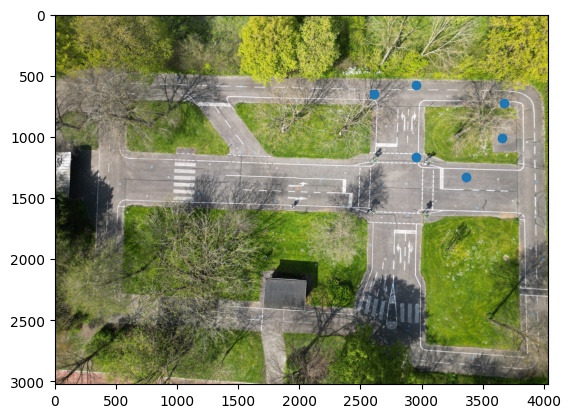

In [86]:
preds = predict(validation_pts_pv_arr, h)
print(preds)
plt.imshow(img_tv)
plt.scatter(preds[:, 0], preds[:, 1])
plt.show()

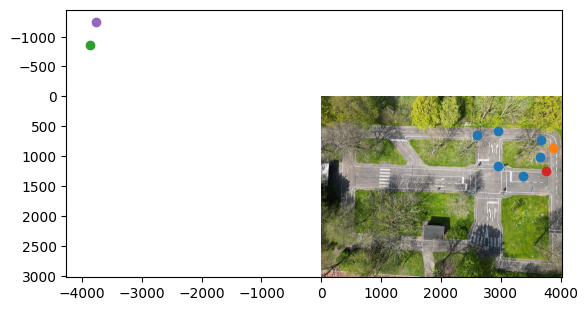

In [78]:
## Print the solutions with adjusted scaling
preds = predict(validation_pts_pv_arr, h)
plt.imshow(img_tv)
plt.scatter(preds[:, 0], preds[:, 1])

for i in range(num):
    # Scale the translation vector
    t = Ts[i].ravel()
    # t_scaled = t / np.linalg.norm(t) * np.linalg.norm(h[:2, 2])
    t_scaled = t*900
    plt.scatter(t_scaled[2], t_scaled[0])

plt.show()

In [85]:
reference_pts_pv_arr[:, :2]

array([[ 452.63769102, 1271.1256671 ],
       [1736.61159685,  897.87051629],
       [ 585.29848376, 1725.23526502],
       [1411.05519253, 1547.04832543],
       [ 708.17166755, 2231.6469422 ],
       [2030.01056455, 2817.13131586],
       [3428.13563284, 2747.69612743],
       [3930.93458596, 1417.87698512],
       [3522.82282947,  845.65371838]])

In [4]:
positions = np.concatenate(
    (pos_0026.T, 
     pos_0029.T, 
     pos_0032.T, 
     pos_0035.T, 
     pos_0038.T,
     pos_0045.T,
     pos_0049.T,
     pos_0053.T,
     pos_0061.T,
     pos_0066.T,
     pos_0067.T,
     pos_0078.T), 
    axis=0)
# I checked all positions manually, and they SEEM to be right! How to quantify it? 
# Height and angle we can do however.
# FoV Maybe also for visual proof.

In [16]:
colors = np.arange(0, len(positions))
labels = [
    'DJI_0026', 
    'DJI_0029', 
    'DJI_0032',
    'DJI_0035',
    'DJI_0038',
    'DJI_0045',
    'DJI_0049',
    'DJI_0053',
    'DJI_0061',
    'DJI_0066',
    'DJI_0067',
    'DJI_0078'
]

_, img_tv = get_images('DJI_0026', 'DJI_0017')

from utils import load_data

validation_pts_tv = load_data(f'data/annotations/DJI_0017_blue.txt')
reference_pts_tv = load_data(f'data/annotations/DJI_0017_white.txt')

In [31]:
colormap(0)

(0.267004, 0.004874, 0.329415, 1.0)

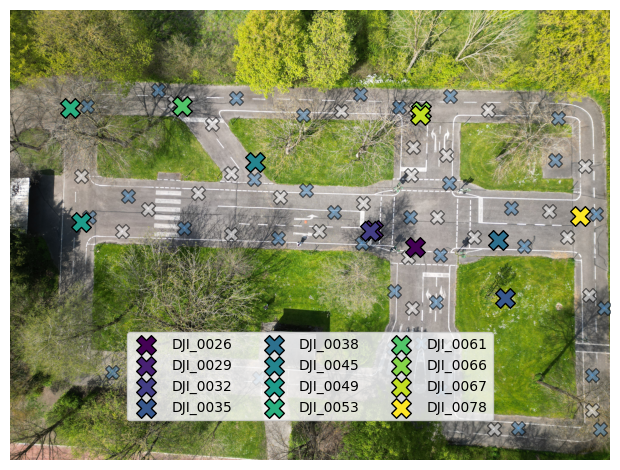

In [27]:
import matplotlib.cm as cm
plt.imshow(img_tv)

norm = plt.Normalize(min(colors), max(colors))
# Use a colormap (e.g., viridis, plasma, etc.)
colormap = plt.colormaps.get_cmap('viridis')

# Plot Reference and Validation Points
for name, pt in reference_pts_tv.items():
    plt.scatter(pt[0], pt[1], marker='X', color='whitesmoke', s=100, ec='black', alpha=0.5)
    
for name, pt in validation_pts_tv.items():
    plt.scatter(pt[0], pt[1], marker='X', color='steelblue', s=100, ec='black', alpha=0.5)

# Plot each point individually with its corresponding label
for i in range(len(positions)):
    color = colormap(norm(colors[i]))
    plt.scatter(positions[i, 0], positions[i, 1], color=color, label=labels[i], marker='X', s=200,
               edgecolors='black')
    

# Create legend with unique labels
handles, unique_labels = plt.gca().get_legend_handles_labels()
unique_labels, unique_handles = zip(*dict(zip(unique_labels, handles)).items())
plt.legend(unique_handles, unique_labels)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.3),
          ncol=3, fancybox=True, shadow=False, framealpha=0.8)
plt.axis('off')

plt.tight_layout()
plt.savefig('camera_positions.png', dpi=300)
plt.show()

In [ ]:
# Wenn ich hier noch die Richtung anzeigen koennte, in die die cameras schauen, 
# das waere super. TODO...

In [148]:
# Die Hoehe ist ja nun -500px unter der Kamera in X meter hoehe.

In [14]:
heights = -positions[:, -1] / SCALING_FACTOR
heights

array([10.07963727,  9.98357661, 10.15311185, 10.19206847, 10.00555131,
        2.78321154, 10.4852342 ,  2.84121707, 10.01564044,  8.01165016,
        7.88798093, 10.254574  ])

In [15]:
for name, height in zip(labels, heights):
    print(f'{name}: {height:.2f}m')

DJI_0026: 10.08m
DJI_0029: 9.98m
DJI_0032: 10.15m
DJI_0035: 10.19m
DJI_0038: 10.01m
DJI_0045: 2.78m
DJI_0049: 10.49m
DJI_0053: 2.84m
DJI_0061: 10.02m
DJI_0066: 8.01m
DJI_0067: 7.89m
DJI_0078: 10.25m


### Rotations

In [4]:
from scipy.spatial.transform import Rotation as R
def get_camera_rotation(pv_img, tv_img='DJI_0017'):
    reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv = load_dataset(pv_img, tv_img)
    img_pv, img_tv = get_images(pv_img, tv_img)

    reference_pts_pv_arr, reference_pts_tv_arr, validation_pts_pv_arr, validation_pts_tv_arr = transform_points(
        reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv)
    reference_pts_pv_arr = reference_pts_pv_arr[:,:2].astype(np.float32)
    reference_pts_tv_arr = reference_pts_tv_arr[:,:2].astype(np.float32) 

    image_points = reference_pts_pv_arr
    object_points = reference_pts_tv_arr
    object_points = np.pad(
        object_points, 
        ((0, 0), (0, 1)), 
        mode = 'constant', 
        constant_values = 0
    )
    
    retval, rvec, tvec = cv2.solvePnP(
        object_points, 
        image_points, 
        K,
        dist
    )
    rotM = cv2.Rodrigues(rvec)[0]
    camera_position = np.matmul(-rotM.T, tvec) 

    rotation = R.from_matrix(rotM)
    
    # Convert the rotation to Euler angles (assuming 'zyx' order)
    euler_angles = rotation.as_euler('zyx', degrees=True)
    
    # Extract the individual angles
    yaw, pitch, roll = euler_angles
    return roll+90
rot_0026 = get_camera_rotation('DJI_0026')
rot_0029 = get_camera_rotation('DJI_0029')
rot_0032 = get_camera_rotation('DJI_0032')
rot_0035 = get_camera_rotation('DJI_0035')
rot_0038 = get_camera_rotation('DJI_0038')
rot_0045 = get_camera_rotation('DJI_0045')
rot_0049 = get_camera_rotation('DJI_0049')
rot_0053 = get_camera_rotation('DJI_0053')
rot_0061 = get_camera_rotation('DJI_0061')
rot_0066 = get_camera_rotation('DJI_0066')
rot_0067 = get_camera_rotation('DJI_0067')
rot_0078 = get_camera_rotation('DJI_0078')

In [5]:
rot_0026

40.867392490041524

### Test rotation on my own

In [51]:
reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv = load_dataset('DJI_0026', 'DJI_0017')
img_pv, img_tv = get_images(pv_img, tv_img)

reference_pts_pv_arr, reference_pts_tv_arr, validation_pts_pv_arr, validation_pts_tv_arr = transform_points(
    reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv)
reference_pts_pv_arr = reference_pts_pv_arr[:,:2].astype(np.float32)
reference_pts_tv_arr = reference_pts_tv_arr[:,:2].astype(np.float32) 

image_points = reference_pts_pv_arr
object_points = reference_pts_tv_arr
object_points = np.pad(
    object_points, 
    ((0, 0), (0, 1)), 
    mode = 'constant', 
    constant_values = 0
)

retval, rvec, tvec = cv2.solvePnP(
    object_points, 
    image_points, 
    K,
    dist
)
rotM = cv2.Rodrigues(rvec)[0]
print(rotM)
camera_position = np.matmul(-rotM.T, tvec) 

rotation = R.from_matrix(rotM)

# Convert the rotation to Euler angles (assuming 'zyx' order)
euler_angles = rotation.as_euler('zyx', degrees=True)

# Extract the individual angles
yaw, pitch, roll = euler_angles

[[ 0.83569466  0.54917963 -0.00402062]
 [-0.35679598  0.54847804  0.75621985]
 [ 0.41750576 -0.63053435  0.65430526]]


In [47]:
print(pitch, yaw, roll)

-0.23036543110029875 -33.31105467827386 -49.132607509958476


#### 1. Get H

In [178]:
pv_img = 'DJI_0026'
tv_img = 'DJI_0017'
reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv = load_dataset(pv_img, tv_img)
img_pv, img_tv = get_images(pv_img, tv_img)

reference_pts_pv_arr, reference_pts_tv_arr, validation_pts_pv_arr, validation_pts_tv_arr = transform_points(
    reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv)

h, _ = cv2.findHomography(
    reference_pts_pv_arr,
    reference_pts_tv_arr,
    # method = cv2.RANSAC,
    method = 0,
)
h_inv = np.linalg.inv(h)

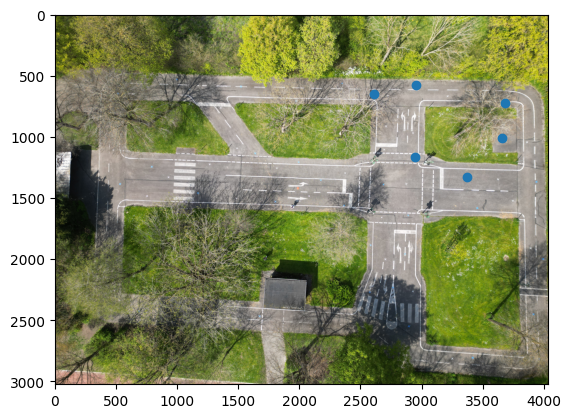

In [179]:
plt.imshow(img_tv)
plt.scatter(validation_pts_tv_arr[:, 0], validation_pts_tv_arr[:, 1])

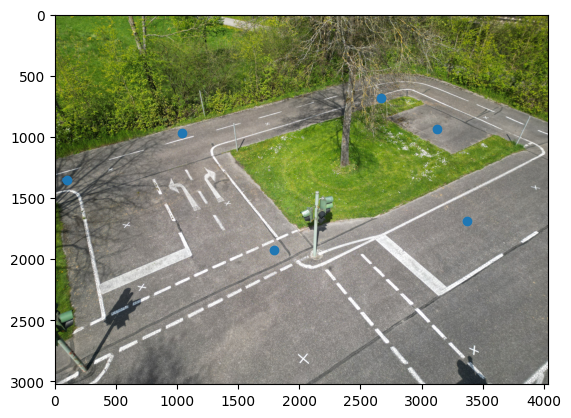

In [181]:
# Test Homography
validation_pts_tv_arr
preds = predict(validation_pts_tv_arr, h_inv)
plt.imshow(img_pv)
plt.scatter(preds[:, 0], preds[:, 1])
plt.show()

In [190]:
num, Rs, Ts, Ns  = cv2.decomposeHomographyMat(h_inv, K)
positions = []
for t, RM in zip(Ts, Rs):
    positions.append(-RM@t)

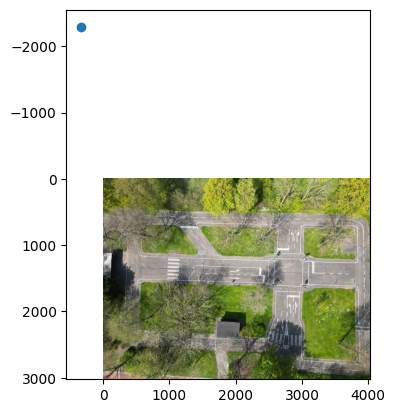

In [199]:
position = positions[0]*3000
plt.imshow(img_tv)
plt.scatter(position[0], position[1])

In [202]:
H = h_inv.T
h1 = H[0]
h2 = H[1]
h3 = H[2]
K_inv = np.linalg.inv(K)
L = 1 / np.linalg.norm(np.dot(K_inv, h1))
r1 = L * np.dot(K_inv, h1)
r2 = L * np.dot(K_inv, h2)
r3 = np.cross(r1, r2)
T = L * (K_inv @ h3.reshape(3, 1))
R = np.array([[r1], [r2], [r3]])
R = np.reshape(R, (3, 3))
T

array([[-3140.18132498],
       [  516.99761629],
       [  225.2886724 ]])

### Calculate r1, r2

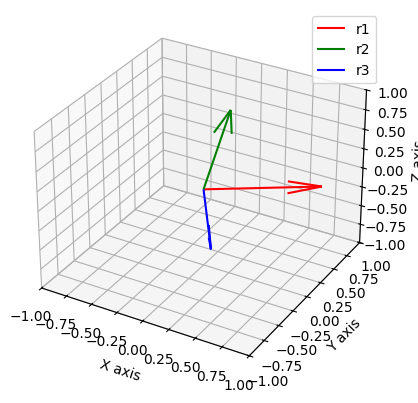

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define the origin
origin = np.array([0, 0, 0])

# Plot the vectors
ax.quiver(*origin, *r1_norm, color='r', label='r1')
ax.quiver(*origin, *r2_norm, color='g', label='r2')
ax.quiver(*origin, *r3_norm, color='b', label='r3')

# Set labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# Set the limits of the axes
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

# Add a legend
ax.legend()

# Show the plot
plt.show()


GT: -43.0

In [272]:
from scipy.spatial.transform import Rotation as R
def calculate_rotation(pv_img):
    reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv = load_dataset(pv_img, 'DJI_0017')
    
    reference_pts_pv_arr, reference_pts_tv_arr, validation_pts_pv_arr, validation_pts_tv_arr = transform_points(
        reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv)
    
    h, _ = cv2.findHomography(
        reference_pts_pv_arr,
        reference_pts_tv_arr,
        # method = cv2.RANSAC,
        method = 0,
    )
    h_inv = np.linalg.inv(h)

    # Our Homography is from PV -> TV
    # Homography should be from TV -> PV?
    # H@XTV

    h1 = h_inv[:, 0]
    h2 = h_inv[:, 1]
    h3 = h_inv[:, 2]
    K_inv = np.linalg.inv(K)
    r1 = K_inv @ h1
    r2 = K_inv @ h2
    # Normalize
    r1_norm = r1 / np.sqrt(np.sum(r1**2))
    r2_norm = r2 / np.sqrt(np.sum(r2**2))
    r3 = np.cross(r1_norm, r2_norm)
    # r3 = np.cross(r2_norm, r1_norm)
    r3_norm = r3 / np.sqrt(np.sum(r3**2))
    
    R_matrix = np.column_stack((r1_norm, r2_norm, r3_norm))
    rotation = R.from_matrix(R_matrix)
    t = -R_matrix@h3 # SHOULD BE -R_matrix
    # Convert the rotation matrix to Euler angles (in radians)
    # The sequence 'xyz' specifies the order of rotations: roll (x), pitch (y), yaw (z)
    euler_angles = rotation.as_euler('xyz', degrees=True)
    # Extract the roll, pitch, and yaw
    roll, pitch, yaw = euler_angles
    return roll, pitch, yaw, t
roll, pitch, yaw, t = calculate_rotation('DJI_0017')
print(roll, pitch, yaw, t)

2.604809386658129e-14 5.088887490341627e-14 8.244498295855875e-15 [ 2.57516788e-13 -1.14748203e-12 -1.00000000e+00]


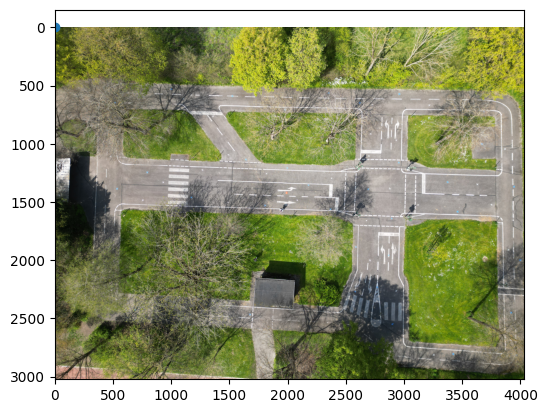

In [274]:
pv_img = 'DJI_0017'
tv_img = 'DJI_0017'
roll, pitch, yaw, t = calculate_rotation(pv_img)
reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv = load_dataset(pv_img, tv_img)
img_pv, img_tv = get_images(pv_img, tv_img)

reference_pts_pv_arr, reference_pts_tv_arr, validation_pts_pv_arr, validation_pts_tv_arr = transform_points(
    reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv)

plt.imshow(img_tv)
plt.scatter(t[0], t[2])
plt.show()

#### STUFF

In [218]:
rotations = [ 
    rot_0026, 
    rot_0029, 
    rot_0032, 
    rot_0035, 
    rot_0038,
    rot_0045,
    rot_0049,
    rot_0053,
    rot_0061,
    rot_0066,
    rot_0067,
    rot_0078
]
for name, rotation in zip(labels, rotations):
    print(f'{name}: {rotation:.2f} deg')

DJI_0026: 40.87 deg
DJI_0029: 40.16 deg
DJI_0032: 41.34 deg
DJI_0035: 41.04 deg
DJI_0038: 36.00 deg
DJI_0045: 25.70 deg
DJI_0049: 36.08 deg
DJI_0053: 29.99 deg
DJI_0061: 41.40 deg
DJI_0066: 36.33 deg
DJI_0067: 44.46 deg
DJI_0078: 34.68 deg


In [305]:
def get_camera_rotation(pv_img, tv_img='DJI_0017'):
    reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv = load_dataset(pv_img, tv_img)
    img_pv, img_tv = get_images(pv_img, tv_img)

    reference_pts_pv_arr, reference_pts_tv_arr, validation_pts_pv_arr, validation_pts_tv_arr = transform_points(
        reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv)
    reference_pts_pv_arr = reference_pts_pv_arr[:,:2].astype(np.float32)
    reference_pts_tv_arr = reference_pts_tv_arr[:,:2].astype(np.float32) 

    image_points = reference_pts_pv_arr
    object_points = reference_pts_tv_arr
    object_points = np.pad(
        object_points, 
        ((0, 0), (0, 1)), 
        mode = 'constant', 
        constant_values = 0
    )
    
    retval, rvec, tvec = cv2.solvePnP(
        object_points, 
        image_points, 
        K,
        dist
    )
    rotM = cv2.Rodrigues(rvec)[0]
    # TODO GET ROTM WRT TO OTHER ROTM !

    # Convert rotation matrix to Euler angles
    r = R.from_matrix(rotM)
    angles = r.as_euler('zyx', degrees=True)
    
    # Add 90 degrees rotation around z-axis
    angles[2] += 90  # Add 90 degrees to the yaw angle
    angles[2] = -angles[2]
    
    # Convert Euler angles back to rotation matrix
    r_modified = R.from_euler('zyx', angles, degrees=True)
    rot_matrix_corrected = r_modified.as_matrix()
    return rot_matrix_corrected
rot_0026 = get_camera_rotation('DJI_0026')
rot_0029 = get_camera_rotation('DJI_0029')
rot_0032 = get_camera_rotation('DJI_0032')
rot_0035 = get_camera_rotation('DJI_0035')
rot_0038 = get_camera_rotation('DJI_0038')
rot_0045 = get_camera_rotation('DJI_0045')
rot_0049 = get_camera_rotation('DJI_0049')
rot_0053 = get_camera_rotation('DJI_0053')
rot_0061 = get_camera_rotation('DJI_0061')
rot_0066 = get_camera_rotation('DJI_0066')
rot_0067 = get_camera_rotation('DJI_0067')
rot_0078 = get_camera_rotation('DJI_0078')

In [306]:
rotations = [
    rot_0026, 
    rot_0029, 
    rot_0032, 
    rot_0035, 
    rot_0038,
    rot_0045,
    rot_0049,
    rot_0053,
    rot_0061,
    rot_0066,
    rot_0067,
    rot_0078
]

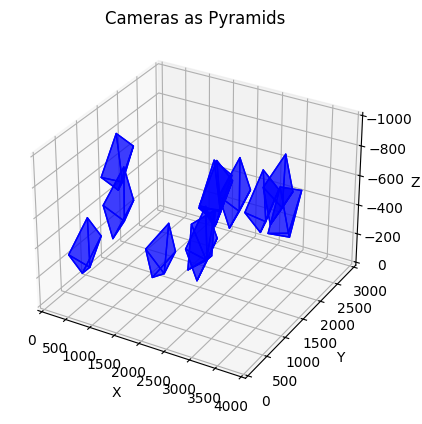

In [307]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_camera(ax, position, rotation_matrix, scale=1):
    # Define camera pyramid vertices (assuming base is a square)
    pyramid_vertices = np.array([[0, 0, 0],
                                  [1, 1, -1],
                                  [1, -1, -1],
                                  [-1, -1, -1],
                                  [-1, 1, -1]], dtype=float)  # Convert to float
    # Scale the pyramid
    pyramid_vertices *= scale
    # Rotate vertices based on rotation matrix
    rotated_vertices = np.dot(pyramid_vertices, rotation_matrix.T) + position
    
    # Define faces of the pyramid
    faces = [[rotated_vertices[0], rotated_vertices[1], rotated_vertices[2]],
             [rotated_vertices[0], rotated_vertices[2], rotated_vertices[3]],
             [rotated_vertices[0], rotated_vertices[3], rotated_vertices[4]],
             [rotated_vertices[0], rotated_vertices[4], rotated_vertices[1]],
             [rotated_vertices[1], rotated_vertices[2], rotated_vertices[3], rotated_vertices[4]]]
    
    # Plot the pyramid
    ax.add_collection3d(Poly3DCollection(faces, color='b', alpha=0.5))

# Example rotation matrix (identity matrix, no rotation)
rotation_matrix = np.eye(3)

# Example camera positions
# camera_positions = np.array([[0, 0, 0],
                             # [2, 2, 2],
                             # [-3, 1, 1]])

camera_positions = positions

# Create figure and axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot cameras
for position, rotation in zip(camera_positions, rotations):
    plot_camera(ax, position, rotation, scale=200)

# Set plot limits and labels
ax.set_xlim([0, 4000])
ax.set_ylim([0, 3000])
ax.set_zlim([0, -1000])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Cameras as Pyramids')

# Show plot
plt.show()